#  Building a State of the Art Bacterial Classifier with fast.ai

The fast.ai library has been breaking records as students use it to produce state of the art results on a myriad of tasks. Some examples given in the course include environmental sound classification and handwritten devanagari prediction.

In this notebook we'll use the library for state of the art bacteria classification with the [DIBaS dataset](http://misztal.edu.pl/software/databases/dibas/). DIBaS (Digital Image of Bacterial Species) contains 660 images, with 33 different genera and species of bacteria.

You can also check out the full blog post on [Building a Bacterial Classifier with fast.ai](https://blog.paperspace.com/building-a-state-of-the-art-bacterial-classifier-with-paperspace-gradient-and-fast-ai/) by Harsh Sikka.

## Load libraries

In [1]:
import os
import requests
import urllib.request
import zipfile
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import error_rate
from bs4 import BeautifulSoup

## Download and extract bacteria dataset

In [2]:
if not os.path.exists('./storage/dibas_zips'):
    os.makedirs('./storage/dibas_zips')

if not os.path.exists('./storage/dibas_images'):
    os.makedirs('./storage/dibas_images')

In [3]:
# Parse the webpage; images are saved in a separate .zip file for each strain of bacteria
url = 'http://misztal.edu.pl/software/databases/dibas/'
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

In [4]:
links = [tag['href'] for tag in soup.findAll('a')]

for link in links:
    if ".zip" in link:
        file_name = link.partition("/dibas/")[2]
        urllib.request.urlretrieve(link, './storage/dibas_zips/' + file_name) 
        zip_ref = zipfile.ZipFile('./storage/dibas_zips/' + file_name, 'r')
        zip_ref.extractall('./storage/dibas_images/')   
        zip_ref.close()
        print("Downloaded and extracted: " + file_name)

Downloaded and extracted: Acinetobacter.baumanii.zip
Downloaded and extracted: Actinomyces.israeli.zip
Downloaded and extracted: Bacteroides.fragilis.zip
Downloaded and extracted: Bifidobacterium.spp.zip
Downloaded and extracted: Candida.albicans.zip
Downloaded and extracted: Clostridium.perfringens.zip
Downloaded and extracted: Enterococcus.faecium.zip
Downloaded and extracted: Enterococcus.faecalis.zip
Downloaded and extracted: Escherichia.coli.zip
Downloaded and extracted: Fusobacterium.zip
Downloaded and extracted: Lactobacillus.casei.zip
Downloaded and extracted: Lactobacillus.crispatus.zip
Downloaded and extracted: Lactobacillus.delbrueckii.zip
Downloaded and extracted: Lactobacillus.gasseri.zip
Downloaded and extracted: Lactobacillus.jehnsenii.zip
Downloaded and extracted: Lactobacillus.johnsonii.zip
Downloaded and extracted: Lactobacillus.paracasei.zip
Downloaded and extracted: Lactobacillus.plantarum.zip
Downloaded and extracted: Lactobacillus.reuteri.zip
Downloaded and extrac

In [2]:
len(os.listdir(('./storage/dibas_images/')))

673

## Verify images

In [3]:
verify_images('./storage/dibas_images/', delete=True, max_size=500)

storage/dibas_images/Micrococcus.spp_0021.tif: Removing corrupt EXIF data
cannot identify image file '/storage/dibas_images/Micrococcus.spp_0021.tif'
cannot identify image file <_io.BufferedReader name='storage/dibas_images/Micrococcus.spp_0023.tif'>
cannot identify image file <_io.BufferedReader name='storage/dibas_images/Listeria.monocytogenes_0023.tif'>


## Train our model

In [2]:
bs = 64
fnames = get_image_files('./storage/dibas_images/')
fnames[:5]

[PosixPath('storage/dibas_images/Escherichia.coli_0005.tif'),
 PosixPath('storage/dibas_images/Propionibacterium.acnes_0009.tif'),
 PosixPath('storage/dibas_images/Streptococcus.agalactiae_0003.tif'),
 PosixPath('storage/dibas_images/Lactobacillus.plantarum_0005.tif'),
 PosixPath('storage/dibas_images/Propionibacterium.acnes_0019.tif')]

In [3]:
np.random.seed(42)
pat = r'/([^/]+)_\d+.tif$'
data = ImageDataBunch.from_name_re('bacteria-dataset/full_images_alt', fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

In [4]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [5]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,3.660002,3.079889,0.744361
2,2.487222,1.224737,0.270677
3,1.817865,0.596912,0.157895
4,1.429206,0.482402,0.135338


## Find optimal learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


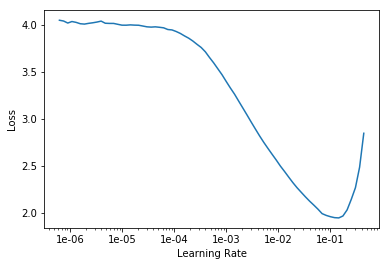

In [6]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)
learn.lr_find()
learn.recorder.plot()

In [7]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate
1,3.332049,2.929144,0.721804
2,2.139436,0.842049,0.210526
3,1.476930,0.358044,0.112782
4,1.114299,0.246035,0.067669
5,0.891746,0.227113,0.075188
6,0.730079,0.210805,0.052632
7,0.608487,0.191650,0.037594
8,0.521280,0.189312,0.045113


In [8]:
learn.save('stage-1-50')
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.177736,0.188096,0.030075
2,0.176430,0.178587,0.030075
3,0.161877,0.177092,0.030075
